In [1]:
import sys
sys.path.append("/users/spate116/singhlab/GCN_Integration/scripts/BI/pyro_model/model")

import os.path as osp

import pyro
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

from model.BayesExplainer import BayesExplainer
from model.samplers.BetaBernoulliSampler import BetaBernoulliSampler
from model.samplers.NFSampler import NFSampler
from model.samplers.SpikeSlabSampler import SpikeSlabSampler
from model.samplers.RandomWalkSampler import RandomWalkSampler
from model.samplers.ConstrainedRandomWalkSampler import ConstrainedRandomWalkSampler

from tqdm.autonotebook import tqdm

dataset = 'Cora'
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear = torch.nn.Linear(16, dataset.num_features)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss -> %.5f" % loss.item())
model.eval()

/users/spate116/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [ ]:
from torch.nn.functional import binary_cross_entropy

def loss(mask, explainer):
    with torch.no_grad():
        preds = explainer.model(explainer.x_adj, explainer.edge_index_adj)[explainer.mapping].reshape(-1).softmax(dim=0).cpu()

    with torch.no_grad():
            preds_masked = explainer.model(explainer.x_adj, explainer.edge_index_adj[:, mask > 0.5])[explainer.mapping].reshape(-1).softmax(dim=0).cpu()

    return binary_cross_entropy(preds, preds_masked).detach().tolist()

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 356.26it/s]


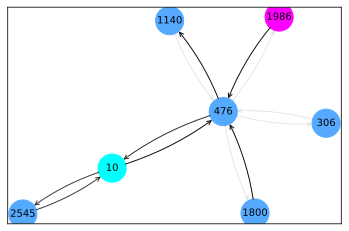

In [ ]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

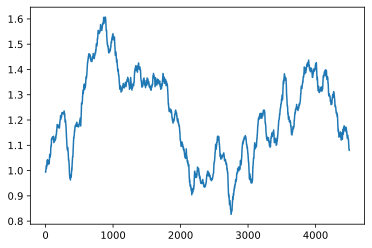

In [ ]:
node_idx = 10
k = 2
sampler = BetaBernoulliSampler("cora_beta_bernoulli", 1.0, 3.0)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=5000, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

In [ ]:
## GNNExplainer Mask
loss(edge_mask[explainer.edge_mask_hard], explainer)

3.0442934075836092e-05

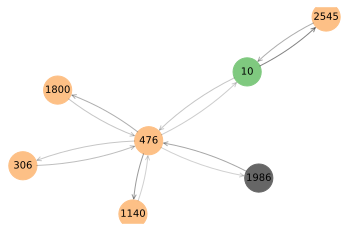

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.2300, 0.4850, 0.2580, 0.2028, 0.2234, 0.3935, 0.3174, 0.1873, 0.1872,
        0.2268, 0.3449, 0.3210], grad_fn=<DivBackward0>)

In [ ]:
loss(edge_mask, explainer)

1.4839887626294512e-05

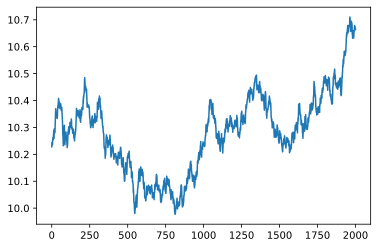

In [ ]:
node_idx = 10
k = 2
splines = 8
sampler = NFSampler("cora_nf_sampler", splines, True, 5, 1, device)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=2500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

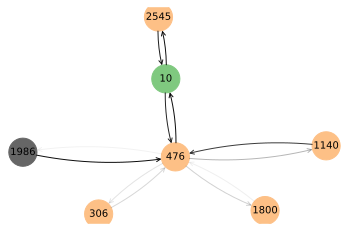

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.8617, 0.9372, 0.1557, 0.9480, 0.1111, 0.2894, 0.1820, 0.0541, 0.7687,
        0.0667, 0.9487, 0.8839], grad_fn=<MeanBackward1>)

In [ ]:
loss(edge_mask, explainer)

1.8346072465647012e-05

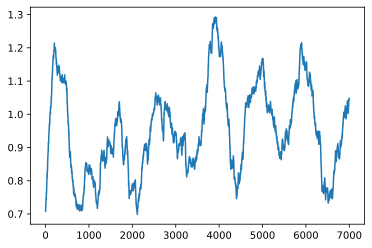

In [ ]:
node_idx = 10
k = 2
sampler = SpikeSlabSampler("cora_spike_slab", 0.25, 1, 5, 10, 1)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=7500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

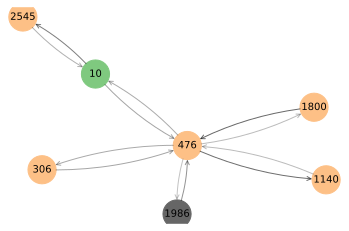

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.3521, 0.5043, 0.3477, 0.3290, 0.3334, 0.5677, 0.2672, 0.2419, 0.2677,
        0.5885, 0.4222, 0.3051], grad_fn=<AddBackward0>)

In [ ]:
loss(edge_mask, explainer)

1.4839887626294512e-05

In [ ]:
node_idx = 10
k = 2
sampler = RandomWalkSampler("random_walk", 0.5)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=10000, lr=0.1, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

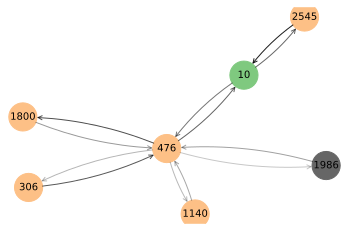

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.5560, 0.5780, 0.6920, 0.6040, 0.2970, 0.2780, 0.7160, 0.1950, 0.3640,
        0.4210, 0.3760, 0.8710])

In [ ]:
loss(edge_mask, explainer)

6.208573904586956e-05

In [ ]:
explainer.edge_index[:, explainer.edge_mask_hard]

tensor([[  10,   10,  306,  476,  476,  476,  476,  476, 1140, 1800, 1986, 2545],
        [ 476, 2545,  476,   10,  306, 1140, 1800, 1986,  476,  476,  476,   10]])

In [ ]:
explainer.sampler.ret_probs(explainer)

[tensor(0.5464, grad_fn=<ClampBackward1>),
 tensor(0.5882, grad_fn=<ClampBackward1>),
 tensor(0.8143, grad_fn=<ClampBackward1>),
 tensor(0.6168, grad_fn=<ClampBackward1>),
 tensor(0.3529, grad_fn=<ClampBackward1>),
 tensor(0.3457, grad_fn=<ClampBackward1>),
 tensor(0.8617, grad_fn=<ClampBackward1>),
 tensor(0.2562, grad_fn=<ClampBackward1>),
 tensor(0.4361, grad_fn=<ClampBackward1>),
 tensor(0.4785, grad_fn=<ClampBackward1>),
 tensor(0.4254, grad_fn=<ClampBackward1>),
 tensor(0.8709, grad_fn=<ClampBackward1>)]